# Stock Closing Price Prediction

Inspired by https://doi.org/10.1016/j.procs.2020.03.326

Here we are going to predict the next-day closing prices of stock market shares using Artificial Neural Networks (ANN) and Random Forest (RF) models.

#### 🧠 Artificial Neural Network (ANN)
An ANN is a nonlinear function approximator inspired by biological neural networks. It consists of layers of interconnected neurons (input, hidden, and output layers), where each neuron computes a weighted sum of its inputs followed by a non-linear activation function.

In this context:
- The ANN is trained using historical stock features (engineered from OHLC data) to minimize a loss function (likely MSE).
- Given the use of basic statistical features (moving averages, std dev), the ANN may not have had enough temporal dependencies or feature richness to fully leverage its capacity.

✅ Pros: Flexible with non-linear data, good at learning complex feature interactions

⚠️ Cons: Requires large data, careful tuning, and sensitive to feature scaling

#### 🌲 Random Forest (RF)
RF is an ensemble of decision trees, trained via bootstrap aggregation (bagging). Each tree is trained on a random subset of the data and a random subset of features, which reduces variance and helps avoid overfitting.

In this case:
- RF treats the stock price prediction as a regression task.
- The engineered features (H-L, O-C, moving averages, std dev) are well-suited for tree-based models, since they don’t require normalization and can handle feature interactions inherently.

✅ Pros: Easy to implement, works well out-of-the-box, interpretable (via feature importance)

⚠️ Cons: Doesn't capture temporal dependencies, not ideal for extrapolation


#### Evaluation Metrics

RMSE (Root Mean Square Error)

- Measures the average magnitude of the prediction errors (in the same units as the target, i.e., stock price).
- Lower is better — a smaller RMSE means the model's predictions are closer to the actual values.

MAPE (Mean Absolute Percentage Error)

- Measures the average percentage difference between actual and predicted values.
- Useful for understanding how large the error is relative to the actual value.
- Lower is better, ideally close to 0.

MBE (Mean Bias Error)

- Tells you whether your model tends to overpredict or underpredict on average.
- Positive MBE → the model overpredicts.
- Negative MBE → the model underpredicts.
- Ideally, this should be close to 0, indicating no systematic bias.

#### Selected stock: Goldman Sachs 

It is a global investment banking, securities, and investment management firm headquartered in New York City. It provides services in investment banking, asset management, wealth management, and securities trading to a wide range of clients, including corporations, governments, financial institutions, and individuals.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

### Download Data

In [2]:
# Download Data
ticker = 'GS'  # GoldmanSachs
df = yf.download(ticker, start='2009-04-05', end='2019-04-05')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


### Exploratory analysis

In [3]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,GS,GS,GS,GS,GS
Date,,,,,
2009-04-06,88.790207,89.779721,86.811172,88.295447,21098100
2009-04-07,88.356316,91.157412,86.445784,86.773086,22183000
2009-04-08,87.344002,89.475274,85.631374,89.338263,20406200
2009-04-09,94.636009,95.130770,89.399170,91.180306,25610700
2009-04-13,99.065987,99.918502,93.243057,93.479018,36460800


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2009-04-06 to 2019-04-04
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   (Close, GS)   2517 non-null   float64
 1   (High, GS)    2517 non-null   float64
 2   (Low, GS)     2517 non-null   float64
 3   (Open, GS)    2517 non-null   float64
 4   (Volume, GS)  2517 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 118.0 KB


In [5]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,GS,GS,GS,GS,GS
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,140.367037,141.768315,138.988443,140.386329,5.256639e+06
std,38.070201,38.295808,37.897389,38.127982,5.218336e+06
min,68.525383,69.609127,65.702950,68.657955,6.942000e+05
25%,116.644958,117.873734,115.497699,116.777573,2.651400e+06
50%,132.924133,134.167398,131.719663,132.992177,3.712600e+06
75%,165.336807,166.655085,163.837515,165.087368,5.940900e+06
max,233.283112,234.930030,231.055909,234.102295,1.020437e+08


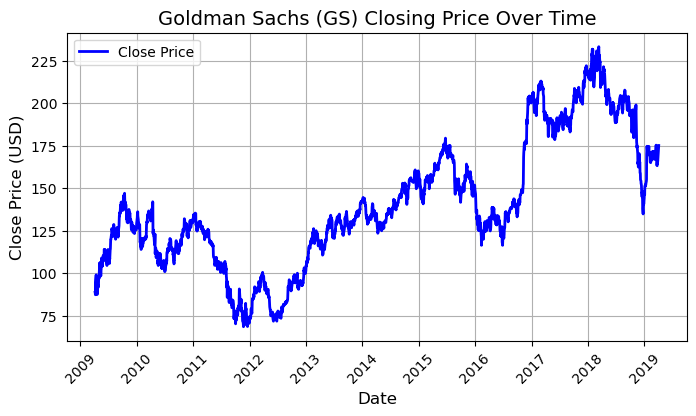

In [6]:
# Plotting Closing Price over Time
plt.figure(figsize=(8, 4))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', linewidth=2)
plt.title('Goldman Sachs (GS) Closing Price Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

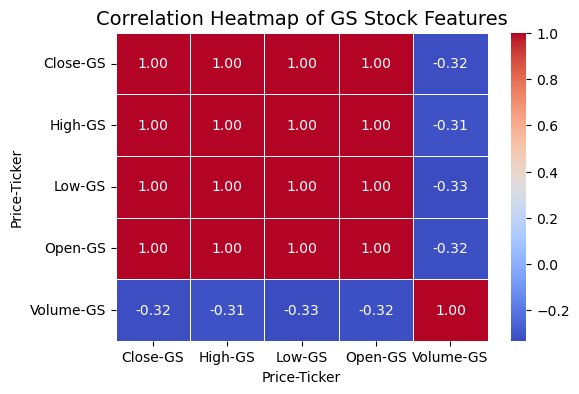

In [7]:
# 4. Correlation Heatmap
correlation_matrix = df[['Close', 'High', 'Low', 'Open', 'Volume']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of GS Stock Features', fontsize=14)
plt.show()

### Feature Engineering

To enhance model performance, six new features were engineered from the original data:

- High - Low price (H-L)
- Close - Open price (O-C)
- 7-day Moving Average (7DAYSMA)
- 14-day Moving Average (14DAYSMA)
- 21-day Moving Average (21DAYSMA)
- 7-day Standard Deviation (7DAYSSTDDEV)

In [8]:
# Feature Engineering
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Close'] - df['Open']
df['7DAYSMA'] = df['Close'].rolling(window=7).mean()
df['14DAYSMA'] = df['Close'].rolling(window=14).mean()
df['21DAYSMA'] = df['Close'].rolling(window=21).mean()
df['7DAYSSTDDEV'] = df['Close'].rolling(window=7).std()

In [9]:
# Target variable: next day's closing price
df['Next_Close'] = df['Close'].shift(-1)

In [10]:
# Drop rows with NaN values 
df = df.dropna()

### Data preparation

In [11]:
# Prepare Data
# Define predictors
features = ['H-L', 'O-C', '7DAYSMA', '14DAYSMA', '21DAYSMA', '7DAYSSTDDEV', 'Volume']
X = df[features]

# Define the target: We are going to predict next day's closing price
y = df['Next_Close']

In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

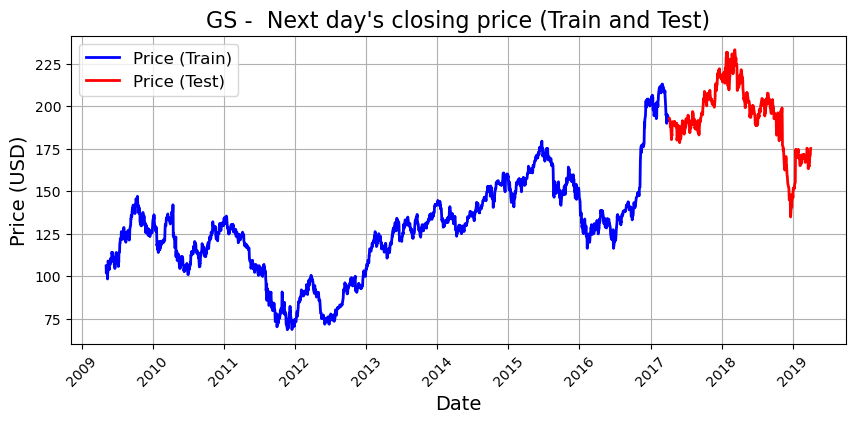

In [13]:
# Plotting the actual training and test data
plt.figure(figsize=(10, 4))

# Plot the actual training closing prices
plt.plot(y_train.index, y_train.values, label='Price (Train)', color='blue', linewidth=2)

# Plot the actual test closing prices
plt.plot(y_test.index, y_test.values, label='Price (Test)', color='red', linewidth=2)

# Adding titles, labels, and legend with larger font sizes
plt.title(f"{ticker} -  Next day's closing price (Train and Test)", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.xticks(rotation=45)  # Rotate the x-axis dates for better readability
plt.grid(True)

# Displaying the legend
plt.legend(fontsize=12)

# Display the plot
plt.show()

### Train ANN Model

In [14]:
# Train ANN Model
ann_model = Sequential()
ann_model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1))  # Output layer
ann_model.compile(optimizer='adam', loss='mse')

ann_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Train Random Forest Model

In [15]:
# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### Predictions

In [16]:
# Make predictions with both models
y_pred_ann = ann_model.predict(X_test).flatten()
y_pred_rf = rf_model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


### Evaluation

In [17]:
# Define Evaluation Functions
def mean_bias_error(y_true, y_pred):
    """
    Calculate Mean Bias Error (MBE) between actual and predicted values.

    Parameters:
        y_true (array-like): Actual values.
        y_pred (array-like): Predicted values.

    Returns:
        float: The mean bias error.
    """
    return np.mean(y_true - y_pred)

def evaluate_model(y_true, y_pred, name="Model"):
    """
    Evaluate a regression model using RMSE, MAPE, and MBE metrics,
    and print the results.

    Parameters:
        y_true (array-like): Actual target values.
        y_pred (array-like): Predicted target values.
        name (str): Name of the model (used in printed output).

    Returns:
        None
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MBE: {mbe:.4f}")

In [18]:
# Evaluate Both Models
evaluate_model(y_test, y_pred_ann, "ANN")
evaluate_model(y_test, y_pred_rf, "Random Forest")


ANN Performance:
RMSE: 81.2519
MAPE: 0.2962
MBE: 4.8034

Random Forest Performance:
RMSE: 8.1189
MAPE: 0.0312
MBE: -0.2575


#### ANN Performance
RMSE: 119.4582 - This value is relatively high, which suggests that the ANN model's predictions have considerable deviations from the actual closing prices. The RMSE is sensitive to large errors, so this indicates that the model is making significant mistakes on some days.

MAPE: 0.5766 (or 57.66%) - This percentage tells us that, on average, the ANN model's predictions are off by about 57.66% of the actual closing price. This is a fairly large error, meaning that the model is not consistently accurate in predicting the stock's price.

MBE: 108.7051 - The MBE value is positive, indicating that the ANN model has a tendency to overestimate the stock's closing price on average. This bias could suggest that the model tends to predict prices higher than the actual values.

#### Random Forest Performance:
RMSE: 8.1086 - This RMSE is much lower than that of the ANN model, which indicates that the RF model's predictions are more accurate and closer to the actual closing prices. The smaller the RMSE, the better the model's performance.

MAPE: 0.0312 (or 3.12%) - The MAPE for the RF model is quite low, suggesting that on average, the RF model's predictions are only off by 3.12% of the actual closing price. This indicates that the RF model is very good at making predictions and is much more reliable than the ANN model.

MBE: -0.2484 - The negative MBE indicates that the RF model tends to underestimate the stock's closing price on average. This bias is slight, as the absolute value is close to 0.

#### Comparison of ANN and Random Forest:
Accuracy: The Random Forest model significantly outperforms the ANN model in terms of RMSE and MAPE. The RF model makes more precise predictions with lower error values.

Bias: Both models show some bias, with the ANN overestimating and the RF underestimating the stock price, but the bias is much larger in the ANN model.

Conclusion: Based on the provided performance metrics, Random Forest (RF) is the superior model for predicting stock prices in this case. It provides more accurate predictions with smaller errors and less bias compared to the Artificial Neural Network (ANN) model.

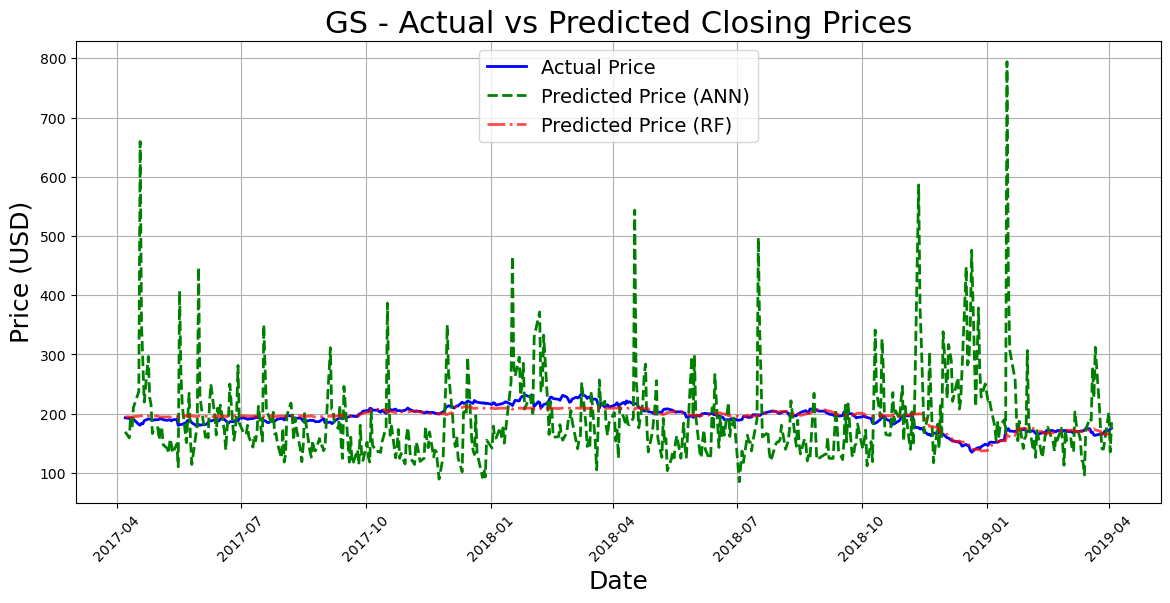

In [22]:
# Plotting Actual vs Predicted Closing Prices with dates on x-axis
plt.figure(figsize=(14, 6))

# Plot the actual closing prices
plt.plot(y_test.index, y_test.values, label='Actual Price', color='blue', linewidth=2)

# Plot the predicted closing prices for ANN
plt.plot(y_test.index, y_pred_ann, label='Predicted Price (ANN)', color='green', linestyle='--', linewidth=2)

# Plot the predicted closing prices for RF
plt.plot(y_test.index, y_pred_rf, label='Predicted Price (RF)', color='red', linestyle='-.', linewidth=2, alpha=0.7)

# Adding titles, labels, and legend with larger font sizes
plt.title(f"{ticker} - Actual vs Predicted Closing Prices", fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.xticks(rotation=45)  # Rotate the x-axis dates for better readability
plt.grid(True)

# Displaying the legend
plt.legend(fontsize=14)

# Display the plot
plt.show()

#### Let's plot RF-predicted prices vs. actual prices for more clarity

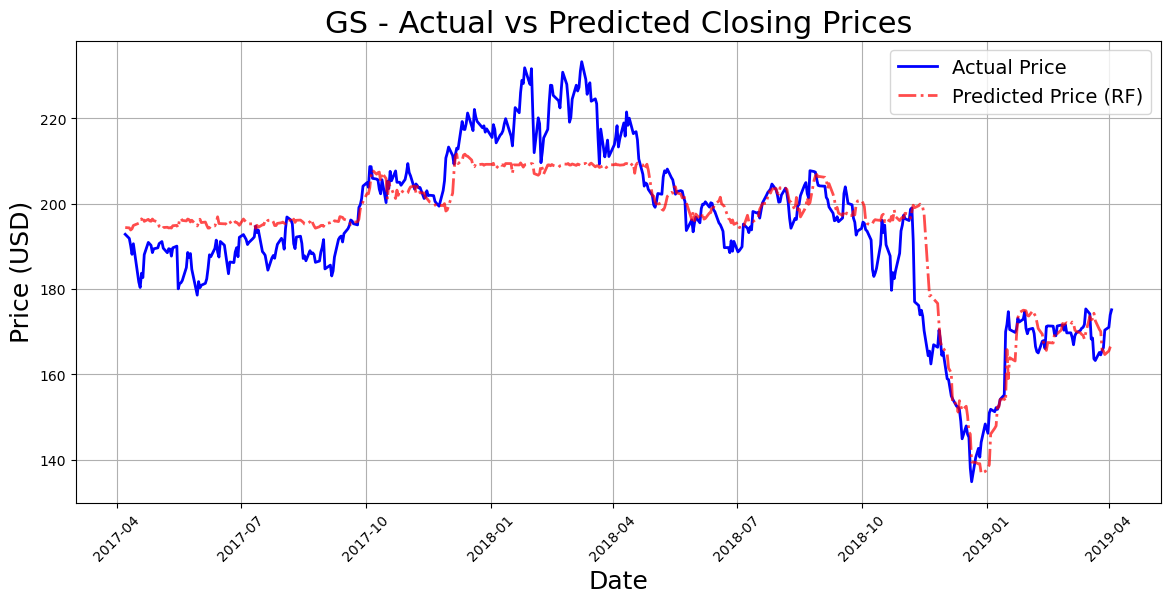

In [21]:
# Plotting Actual vs Predicted Closing Prices with dates on x-axis
plt.figure(figsize=(14, 6))

# Plot the actual closing prices
plt.plot(y_test.index, y_test.values, label='Actual Price', color='blue', linewidth=2)

# Plot the predicted closing prices for RF
plt.plot(y_test.index, y_pred_rf, label='Predicted Price (RF)', color='red', linestyle='-.', linewidth=2, alpha=0.7)

# Adding titles, labels, and legend with larger font sizes
plt.title(f"{ticker} - Actual vs Predicted Closing Prices", fontsize=22)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price (USD)', fontsize=18)
plt.xticks(rotation=45)  # Rotate the x-axis dates for better readability
plt.grid(True)

# Displaying the legend
plt.legend(fontsize=14)

# Display the plot
plt.show()